# Identifying Pneumonina using Convolutional Neural Networks

- Student Name: Kevin Spring
- Student pace: Flex
- Scheduled Project Review: December 12, 2022
- Instructor name: Morgan Jones
- Blog Post

# Summary
Pneumonia is the second highest reason for admittance to a hospital in the United States. It is responsible for over 50,000 deaths in the U.S. per year. The gold standard to diagnose pneumonia is through a chest x-ray but the amount of medical imaging is increasing by 5% a year and there is a shortage of radiologists to screen the medical images. United Healthcare needs an application that can accurately classify chest x-rays as normal or pneumonia. This will reduce the costs of diagnosing pneumonia by reducing the work load for screening x-rays on radiologists. A convolutional neural network was developed using tensorflow on structured x-ray images organized into normal and pneumonia. The images were randomly sorted into training, validation, and testing datasets. The classes were weighted to account for class imbalance between the normal and pneumonia images. The data was also augmented by rotating and zooming into the images to create a larger dataset. The best model used transfer learning and has an testing accuracy of 92.2%, recall of 90.8%, and specificity of 96%. This model uses a pretrained neural network called VGG19 with a dropout layer to reduce overfitting. I deployed a web application using the python library steamlit that allows users to upload images of a chest x-ray and display the normal or pneumonia classification according to the model.

# Table of Contents

# Introduction
In the United States, pneumonia is the second most likely reason a person is admitted to a hospital, behind the birth of a child. Over 1 million adults will be admitted for pneumonia and complications each year. There are many clinical presentations of pneumonia from mild disease with limited shortness of breath and productive cough to severe disease with fever, respiratory distress, and sepsis. Due to the wide spectrum of associated clinical features, pneumonia is a one of the differential diagnosis when assessing acute respiratory illnesses.

Pneumonia will keep an inflicted person's lungs from getting enough oxygen into their blood and is caused by inflamation around the air sacs of lungs. These air sacs may be filled with fluid or pus. Infections of fungi, viruses, or bacteria, or irritation from environmental factors may lead to pneumonia. According to the Center for Disease Control and Prevention (CDC) there are 14.4 deaths caused by pneumonia per 100,000 people in the population. That is about 50,000 death a year in the United States.

Early detection is critical in preventing death due to pneumonia. According to guidelines by the American Thoracic Society and Infectious Disease Society of America, the presence of an opacity on chest imaging in a patient with a compatible clinical syndrome is the gold standard for diagnosis of pneumonia. A radiologist will interpret the x-ray and look for white spots, called infiltrates. Once diagnosed, treatment can begin to remove the excess fluid in the lungs.

## Business Problem

The Association of American Medical Colleges (AAMC) projects to have a serious shortage of radiologists by 2033, while medical images increases by about 5% a year. This will lead to worse patient outcomes as fewer radiologists need are available to make a diagnosis on an increasing number of medical images.

Our company, United Healthcare, is an medical insurance company that provides health insurance through private and Affordable Care Act (ACA) health insurance exchanges. We are expanding our coverage to more rural clients and hospitals but this is where the shortage of specialty care such as radiology is in crisis. Reducing the bottleneck in pneumonia diagnosis will reduce the time a patient is admitted to the hospital and reduce costs associated with this care.

### Project Objective

United Healthcare needs to develop an application to classify chest x-ray images with pneumonia or not (normal). Those predicted to have pneumonia would be forwarded to a radiologist for a confirmed diagnosis. This will lessen the burden and cost of radiologists reviewing chest x-rays that are not indicative of pneumonia.

## Stakeholders

- United Healthcare executives
    * Feasability and implementation of the application
- Healthcare workers
    * Users of the application

# Data
## Data Source
To find a solution to this business problem we need labeled chest x-ray images. There is a freely available dataset found on [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia), originally collected by [Kermany et al](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5), with 5,863 x-ray images in JPEG format  labeled 'val', 'test', and 'train'. Within each of those directories the images are in folders 'PNEUMONIA' or 'NORMAL'

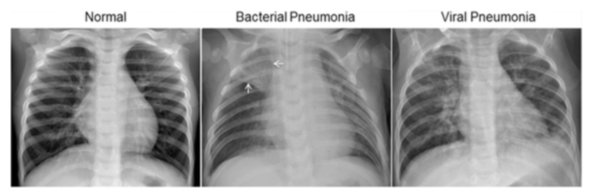

The data found in the `NORMAL` and `PNEUMONIA` folders were compiled together separately . These were then split into training and testing data using the python library [`python_splitter`](https://github.com/bharatadk/python_splitter).

In [1]:
# Unpack the data.zip from Kaggle and turn into test-train split using python_splitter
# 80% will be in training, 20% in testing

import os
# absolute path of unzipped data directory
PATH = os.path.join(os.path.abspath(os.getcwd()),'data/')

# Uncomment the lines below to install python_splitter and create the
# trian test split
#!pip install python_splitter
#from python_splitter import split_from_folder # https://github.com/bharatadk/python_splitter
#split_from_folder(PATH, train = 0.8, test=0.2)

The [cleaned data](https://drive.google.com/file/d/1__QzvDDuMxaYDhZ1o5A98Pbsk4SlUneV/view?usp=share_link) used for this analysis is available to download.

In [ ]:
# Check for class imbalance between pneumonia and normal classified images
def file_count(path, class_name):
    '''
    This helper function takes a file directory and counts
    the number of files in each subdirectory.
    '''
    import os
    dir_path = os.path.join(path, class_name + '/')
    count = 0
    for root_dir, cur_dir, files in os.walk(dir_path):
        count += len(files)
    print(f'{class_name} file count: {count}')
    return count

In [19]:
# Identify counts of each class 
normal_count = file_count(PATH, 'NORMAL')
pneumonia_count = file_count(PATH, 'PNEUMONIA')
total_count = normal_count + pneumonia_count

# Create class weights to correct for imbalance
normal_weight = total_count / (2*normal_count)
pneumonia_weight = total_count / (2*pneumonia_count)

print(f'\nClass Weights')
print(f'NORMAL weight: {normal_weight}')
print(f'PNEUMONIA weight: {pneumonia_weight}')

NORMAL file count: 1583
PNEUMONIA file count: 4273

Class Weights
NORMAL weight: 1.8496525584333543
PNEUMONIA weight: 0.6852328574771823


### Class Imbalance

The data consists of chest x-ray images of those that have pneumonia and those that do not (normal).
There is a total of 5,856 images of which 27% are in the normal class and 73% are in the pneumonia
class. This data is imbalanced and a model would be more exposed to images classified as pneumonia. This could lead to the model classifing every image in this dataset as having pneumonia and it would be 73% accurate.

I can set the class weights attribute in keras to give more wieghts to the underrepresented class. Class weights are inversely proportional to their respective frequencies. The formula to calculate the class weights is:

$$w_j = \frac{n_{j}}{{N} \times n_{j}}$$

Where,
* $w_j$ weight of class $j$
* ${N}$ is the total number of samples in all classes
* $n_{j}$ is the number of samples in class $j$

The weight attribute will tell the model to pay more attention to samples from the under-represented class, normal.

In [3]:
# Set directories for the train-test data
import os#, shutil

data_path = os.path.join(os.path.abspath(os.getcwd()),'Train_Test_Folder/')
train_dir = os.path.join(data_path, 'train/')
test_dir = os.path.join(data_path, 'test/')
train_normal = os.path.join(train_dir, 'NORMAL/')
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA/')

The images are chest x-rays with variable resolution and image size. They are in grayscale format.

In [5]:
# Import data into tensorflow Dataset object
from tensorflow.keras.utils import image_dataset_from_directory

img_height = 240
img_width = 240
grayscale = 1
batch_size = 64

train_ds, val_ds = image_dataset_from_directory(train_dir,
                                        color_mode='grayscale',
                                        label_mode='binary',
                                        validation_split=0.2,
                                        subset='both',
                                        seed=42,
                                        image_size=(img_height, img_width),
                                        batch_size = batch_size)


test_ds = image_dataset_from_directory(test_dir,
                                       #shuffle=False,
                                       color_mode='grayscale',
                                       label_mode='binary',
                                       image_size=(img_height, img_width)
                                      )

# print out the number of batches and data type
print('Batches for testing -->', test_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())
print('Batches for training -->', train_ds.cardinality())

2023-01-09 11:08:00.433256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 4684 files belonging to 2 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 2 classes.
Batches for testing --> tf.Tensor(37, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(15, shape=(), dtype=int64)
Batches for training --> tf.Tensor(59, shape=(), dtype=int64)


In [6]:
# Display tensor shape of data in tensorflow object
print(train_ds.class_names)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['NORMAL', 'PNEUMONIA']
(64, 240, 240, 1)
(64, 1)


Image number: 1266
normal picture title:  NORMAL2-IM-0661-0001.jpeg
pneumonia picture title: person1424_virus_2437.jpeg


Text(0.5, 1.0, 'Pneumonia')

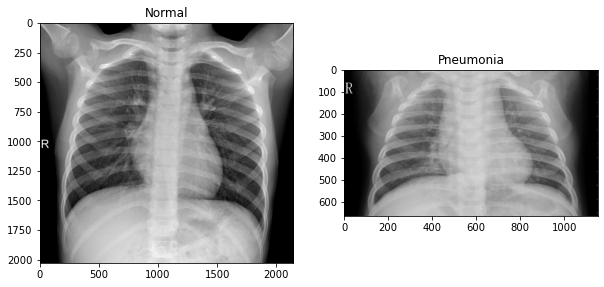

In [4]:
# Show a representative image of the data
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print(f'Image number: {len(os.listdir(train_normal))}')
rand_norm = np.random.randint(0, len(os.listdir(train_normal)))
norm_img = os.listdir(train_normal)[rand_norm]
print('normal picture title: ', norm_img)
norm_img_address = train_normal+norm_img

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_pneumonia)))

pneu_img =  os.listdir(train_pneumonia)[rand_norm]
pneu_img_address = train_pneumonia+pneu_img
print('pneumonia picture title:', pneu_img)

# Load the image
norm_load = Image.open(norm_img_address)
pneu_load = Image.open(pneu_img_address)

# Show the picture
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap='gray')
ax1.set_title('Normal')

ax2 = fig.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneu_load, cmap='gray')
ax2.set_title('Pneumonia')

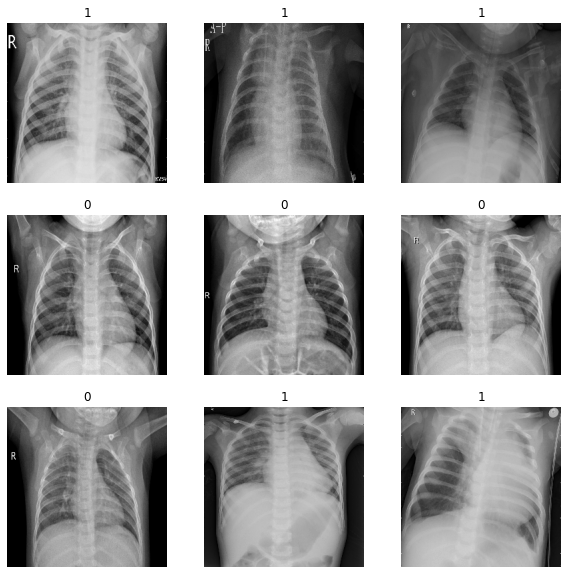

In [7]:
# Visualize the data stored in the tensorflow object
# 0 = normal
# 1 = pneumonia
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')
        plt.title(int(labels[i]))
        plt.axis('off')

In [8]:
# Configure the dataset for performance
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training the model.
# Dataset.prefetch overlaps data preprocessing and model execution while training.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modeling
Convolutional Neural Networks (CNN) is a machine learning technique that reduces the high dimensionality of data such as images without reducing its information. CNNs have outperformed other machine learning algorithms in image classification and is what I will use to train models on the x-ray image data.

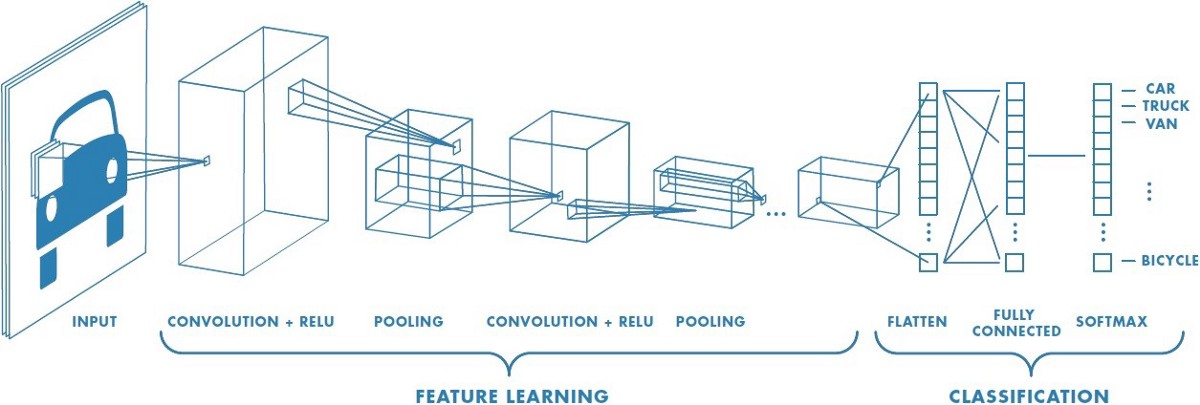

While densly connected neural networks learn global patterns in ther input feature space, convolution layers learn local paterns, that are found in 2-dimensional windows. This allows CNNs to learn patterns that are translation-invariant, something learned in one part of the image can be reused in another part. CNNs can also learn spatial heirarchies of patterns. The first layer of a CNN learns small local patterns such as edges. The next layer will learn larger patterns.

![CNN spatial hierarchies](img/spatial_hierarchy.PNG)

In [9]:
# libraries for neural networks
#from tensorflow import keras
from tensorflow.keras.models import Sequential
import keras
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Rescaling
from keras.layers import BatchNormalization
from keras.metrics import SpecificityAtSensitivity

In [10]:
def plot_fun(model, epochs, file_name):
    '''
    Plotting helper function.
    Plots the Training and validation accuracy
    as well as the training and validation loss
    over the number of epochs specified
    '''
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(epochs)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    #plt.figure(figsize=(12, 4))
    #plt.subplot(1, 2, 1)
    ax[0].plot(epochs_range, acc, 'g-', label='Training Accuracy')
    ax[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    ax[0].legend(loc='lower right')
    #ax[0].title('Training and Validation Accuracy')
    ax[1].title.set_text('Training and Validation Accuracy')

    #plt.subplot(1, 2, 2)
    ax[1].plot(epochs_range, loss, 'g-', label='Training Loss')
    ax[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    ax[1].legend(loc='upper right')
    ax[1].title.set_text('Training and Validation Loss')
    #ax[1].title('Training and Validation Loss')
    fig.patch.set_facecolor('white')
    plt.savefig(f'plots/{file_name}.pdf')
    plt.show()

In [11]:
def confusion_matrix_plot(ds, model, file_name):
    '''
    Confusion Matrix Plot
    Modified from https://stackoverflow.com/a/66872173/1144724
    '''
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    ds_list = list(ds)
    features = np.concatenate([ds_list[n][0] for n in range(0, len(ds_list))])
    true_id = np.concatenate([ds_list[n][1] for n in range(0, len(ds_list))])
    
    # Create pedictions
    predicted_id = model.predict(features)
    predicted_id[predicted_id > 0.5] = 1 # prediction less than 0.5 are normal (0)
    predicted_id[predicted_id < 0.5] = 0 # predictions greater than 0.5 are pneumonia (1)

    # Calculate confusion matrix
    cm_norm = confusion_matrix(true_id, predicted_id,  
                               normalize =None)
    tn, fp, fn, tp = confusion_matrix(true_id, predicted_id, labels=[0,1]).ravel()    
    
    # Make confusion matrix figure
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(1,1,1)
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(cm_norm, annot=True, annot_kws={"size": 12},
         cbar = False, cmap='Greens', fmt='g');
    ax1.set_ylabel('True Values',fontsize=14)
    ax1.set_xlabel('Predicted Values',fontsize=14)
    plt.grid(False)
    plt.savefig(f'plots/{file_name}.pdf')
    plt.show()
    
    # Print validation metrics
    print('Metrics')
    print(f'Accuracy: {(tp+tn)/(tp+tn+fp+fn)*100:,.2f}%')
    print(f'Recall: {tp/(tp+fn)*100:,.2f}%')
    print(f'Specificity: {tn/(tn+fp)*100:,.2f}%')
    print(f'False Positive Rate: {fp/(fp+tn)*100:,.2f}%')
    

## Model 1: Baseline model
This model implements a simple CNN first. It rescales the the pixel data within the image to have a value between 0 and 1. It has a single CNN layer and then downsizes the output through a max pooling layer. That is then flattened and put into a dense layer with one output. This output is the classification of whether the image is classified as pneumonia (1) or normal (0).

In [14]:
#import tensorflow.keras import layers

batch_size = 64
learning_rate = 0.001 #5e-4 #1e-3 #3e-4 # default: 0.001
epochs = 30

# Baseline model
inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model_baseline = keras.Model(inputs=inputs, outputs=outputs, name='baseline_model')

# Compile the Neural network
model_baseline.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.9),
                                   keras.metrics.SensitivityAtSpecificity(0.9)])

# Summary
model_baseline.summary()

# Save model at best point
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/baseline_model.keras',
        save_best_only=True,
        monitor='val_loss')
        ]

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 1)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 240, 240, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 238, 238, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 119, 119, 32)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 453152)            0         
                                                                 
 dense_4 (Dense)             (None, 1)                 453153    
                                                    

In [17]:
# Fit model
class_weights = {0: normal_weight,
                1: pneumonia_weight}

model_baseline_fit = model_baseline.fit(train_ds,
                                         epochs=epochs,
                                         validation_data = val_ds,
                                         batch_size=batch_size,
                                         callbacks=callbacks,
                                         class_weight=class_weights)

Epoch 1/30
59/59 [==============================] - 27s 370ms/step - loss: 0.4050 - accuracy: 0.8204 - recall: 0.8237 - specificity_at_sensitivity: 0.6833 - sensitivity_at_specificity: 0.7137 - val_loss: 0.3359 - val_accuracy: 0.8622 - val_recall: 0.8159 - val_specificity_at_sensitivity: 0.9675 - val_sensitivity_at_specificity: 0.9536
Epoch 2/30
59/59 [==============================] - 21s 351ms/step - loss: 0.1842 - accuracy: 0.9317 - recall: 0.9293 - specificity_at_sensitivity: 0.9588 - sensitivity_at_specificity: 0.9611 - val_loss: 0.2294 - val_accuracy: 0.9060 - val_recall: 0.8768 - val_specificity_at_sensitivity: 0.9797 - val_sensitivity_at_specificity: 0.9783
Epoch 3/30
59/59 [==============================] - 20s 337ms/step - loss: 0.1410 - accuracy: 0.9466 - recall: 0.9446 - specificity_at_sensitivity: 0.9745 - sensitivity_at_specificity: 0.9732 - val_loss: 0.1158 - val_accuracy: 0.9583 - val_recall: 0.9725 - val_specificity_at_sensitivity: 0.9878 - val_sensitivity_at_specifici

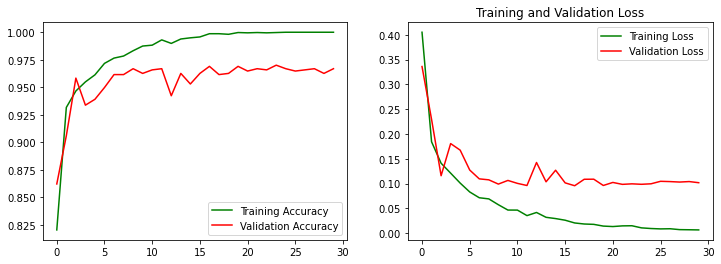

30/30 [==============================] - 1s 49ms/step


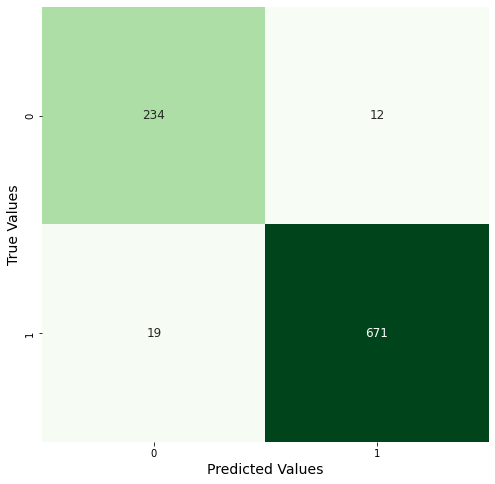

Metrics
Accuracy: 96.69%
Recall: 97.25%
Specificity: 95.12%
False Positive Rate: 4.88%


In [20]:
epochs = 30
plot_fun(model_baseline_fit, epochs, 'baseline_model_plot_accuracy')
confusion_matrix_plot(val_ds, model_baseline, 'baseline_model_confusion_matrix_val')

### Discussion of model 1

The baseline model did very well in classifying the normal and pneumonia x-ray images. Accuracy and specificity is above the acceptable level of 90%. The training and validation accuracy/loss converges very quickly which may indicate it is overfitting. I may be able to improve upon the baseline model by adding more layers, but it is possible this will increase overfitting because of the small amout of data images.

The false positive rate is around 5% which means there are cases of pneumonia that are not being caught. Althought it is a low false positive rate since we are in a medical setting, missing these cases would not be reviewed by a radiologists for confirmation. I want to reduce this value as much as possible without sacrificing accuracy and recall.

## Model 2
The baseline model is extremely good and beats our required metric of 90% for accuracy and around the 5% threshold I set for false positives. It is possible to improve on these metrics by modifying some settings and increasing layers, but we need to be careful about overfitting as I have a small dataset. The second model increases the number of layers in the CNN from one to three.

In [21]:
# Model 2
inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2, padding='same')(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2, padding='same')(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2, padding='same')(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs, name='model_2')

# Compile the Neural network
model2.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.9),
                                   keras.metrics.SensitivityAtSpecificity(0.9)])

# Summary
model2.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model2.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 1)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 240, 240, 1)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 240, 240, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 120, 120, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 60, 60, 64)       0         
 g2D)                                                      

In [22]:
# Fit model
epochs=30
model2_fit = model2.fit(train_ds,
                        steps_per_epoch=len(train_ds),
                        epochs=epochs,
                        validation_data = val_ds,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        class_weight=class_weights,
                        verbose=1)

Epoch 1/30
59/59 [==============================] - 91s 2s/step - loss: 0.4264 - accuracy: 0.8135 - recall_2: 0.8215 - specificity_at_sensitivity_2: 0.6833 - sensitivity_at_specificity_2: 0.6851 - val_loss: 0.2338 - val_accuracy: 0.9092 - val_recall_2: 0.9014 - val_specificity_at_sensitivity_2: 0.9309 - val_sensitivity_at_specificity_2: 0.9232
Epoch 2/30
59/59 [==============================] - 96s 2s/step - loss: 0.1929 - accuracy: 0.9224 - recall_2: 0.9223 - specificity_at_sensitivity_2: 0.9441 - sensitivity_at_specificity_2: 0.9417 - val_loss: 0.2275 - val_accuracy: 0.9049 - val_recall_2: 0.8754 - val_specificity_at_sensitivity_2: 0.9756 - val_sensitivity_at_specificity_2: 0.9710
Epoch 3/30
59/59 [==============================] - 90s 2s/step - loss: 0.1579 - accuracy: 0.9389 - recall_2: 0.9366 - specificity_at_sensitivity_2: 0.9618 - sensitivity_at_specificity_2: 0.9681 - val_loss: 0.2239 - val_accuracy: 0.9071 - val_recall_2: 0.8812 - val_specificity_at_sensitivity_2: 0.9797 - val

Epoch 25/30
59/59 [==============================] - 87s 1s/step - loss: 0.0798 - accuracy: 0.9699 - recall_2: 0.9674 - specificity_at_sensitivity_2: 0.9961 - sensitivity_at_specificity_2: 0.9912 - val_loss: 0.1577 - val_accuracy: 0.9541 - val_recall_2: 0.9623 - val_specificity_at_sensitivity_2: 0.9756 - val_sensitivity_at_specificity_2: 0.9710
Epoch 26/30
59/59 [==============================] - 91s 2s/step - loss: 0.0233 - accuracy: 0.9923 - recall_2: 0.9919 - specificity_at_sensitivity_2: 1.0000 - sensitivity_at_specificity_2: 1.0000 - val_loss: 0.1878 - val_accuracy: 0.9466 - val_recall_2: 0.9710 - val_specificity_at_sensitivity_2: 0.9715 - val_sensitivity_at_specificity_2: 0.9652
Epoch 27/30
59/59 [==============================] - 91s 2s/step - loss: 0.0157 - accuracy: 0.9947 - recall_2: 0.9941 - specificity_at_sensitivity_2: 1.0000 - sensitivity_at_specificity_2: 0.9993 - val_loss: 0.1879 - val_accuracy: 0.9551 - val_recall_2: 0.9609 - val_specificity_at_sensitivity_2: 0.9756 - 

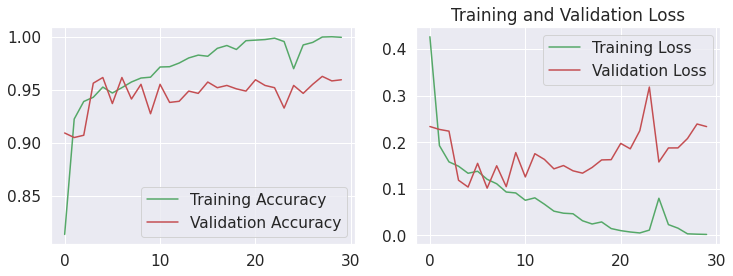

30/30 [==============================] - 7s 221ms/step


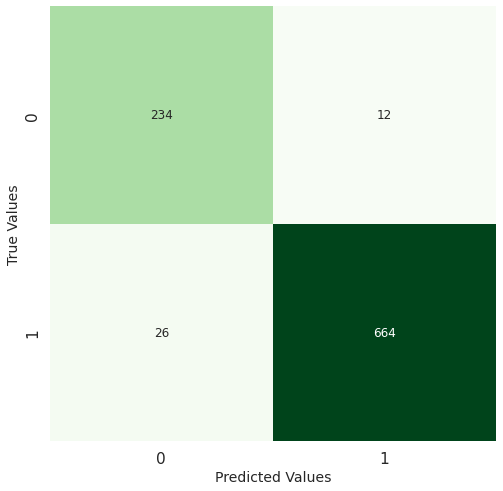

Metrics
Accuracy: 95.94%
Recall: 96.23%
Specificity: 95.12%
False Positive Rate: 4.88%


In [23]:
plot_fun(model2_fit, epochs, 'model_2_accuracy')
confusion_matrix_plot(val_ds, model2, 'model_2_confusion_matrix')

## Discussion
Model 2 has similar but slightly worse validation metrics (accuracy: 96%, recall: 96%, specificity: 95%) than model 1 (accuracy: 97%, recall: 97%, specificity: 95%). We can reduce possible overfitting by adding a dropout layer. This will randomly select which neurons to keep for the model when fitting the training data. The next goal is to maximize generalization performance with regularization.

## Model 3
Model 3 includes a dropout layer. A dropout layer will randomly drop some of the weights propogated in the neural network. The random dropout force the network to learn patterns that are useful for general regularization and avoid overfitting.

In [18]:
# Model 3
# Include a dropout
from keras.layers import Dropout

#learning_rate = 0.001
#batch_size=32

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs, name='model_3')

# Compile the Neural network
model3.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.9),
                                   keras.metrics.SensitivityAtSpecificity(0.9)])

# Summary
model3.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model3.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 1)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 240, 240, 1)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 240, 240, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 120, 120, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                       

In [19]:
# Fit model
epochs=40
model3_fit = model3.fit(train_ds,
                        #steps_per_epoch=len(train_ds),
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         class_weight=class_weights)

Epoch 1/40
59/59 [==============================] - 79s 1s/step - loss: 0.3746 - accuracy: 0.8410 - recall_2: 0.8383 - specificity_at_sensitivity_2: 0.7373 - sensitivity_at_specificity_2: 0.7837 - val_loss: 0.5102 - val_accuracy: 0.7842 - val_recall_2: 0.7087 - val_specificity_at_sensitivity_2: 0.9472 - val_sensitivity_at_specificity_2: 0.9391
Epoch 2/40
59/59 [==============================] - 78s 1s/step - loss: 0.1960 - accuracy: 0.9240 - recall_2: 0.9241 - specificity_at_sensitivity_2: 0.9461 - sensitivity_at_specificity_2: 0.9443 - val_loss: 0.1791 - val_accuracy: 0.9327 - val_recall_2: 0.9159 - val_specificity_at_sensitivity_2: 0.9797 - val_sensitivity_at_specificity_2: 0.9652
Epoch 3/40
59/59 [==============================] - 78s 1s/step - loss: 0.1508 - accuracy: 0.9424 - recall_2: 0.9435 - specificity_at_sensitivity_2: 0.9686 - sensitivity_at_specificity_2: 0.9652 - val_loss: 0.1613 - val_accuracy: 0.9327 - val_recall_2: 0.9188 - val_specificity_at_sensitivity_2: 0.9837 - val

Epoch 25/40
59/59 [==============================] - 79s 1s/step - loss: 0.0016 - accuracy: 1.0000 - recall_2: 1.0000 - specificity_at_sensitivity_2: 1.0000 - sensitivity_at_specificity_2: 1.0000 - val_loss: 0.1821 - val_accuracy: 0.9551 - val_recall_2: 0.9522 - val_specificity_at_sensitivity_2: 0.9878 - val_sensitivity_at_specificity_2: 0.9826
Epoch 26/40
59/59 [==============================] - 78s 1s/step - loss: 0.0016 - accuracy: 1.0000 - recall_2: 1.0000 - specificity_at_sensitivity_2: 1.0000 - sensitivity_at_specificity_2: 1.0000 - val_loss: 0.1571 - val_accuracy: 0.9615 - val_recall_2: 0.9681 - val_specificity_at_sensitivity_2: 0.9878 - val_sensitivity_at_specificity_2: 0.9797
Epoch 27/40
59/59 [==============================] - 78s 1s/step - loss: 0.0016 - accuracy: 1.0000 - recall_2: 1.0000 - specificity_at_sensitivity_2: 1.0000 - sensitivity_at_specificity_2: 1.0000 - val_loss: 0.1598 - val_accuracy: 0.9637 - val_recall_2: 0.9696 - val_specificity_at_sensitivity_2: 0.9837 - 

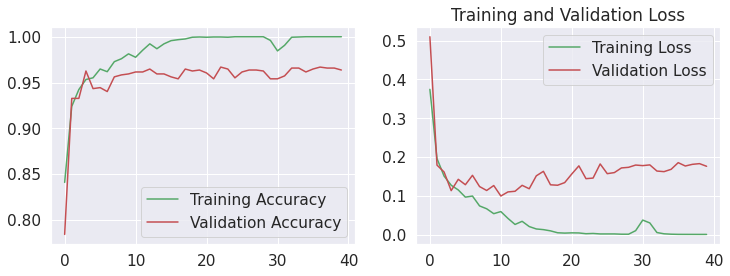

30/30 [==============================] - 5s 167ms/step


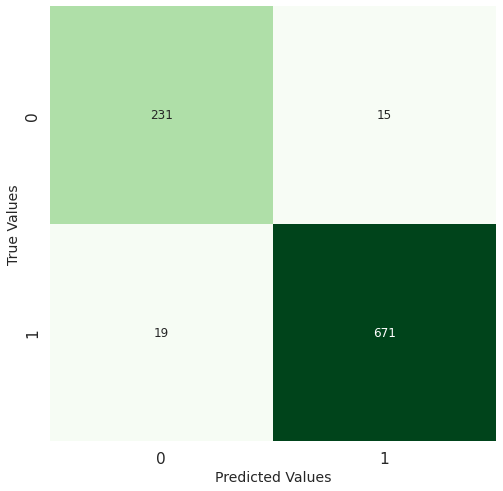

Validation metrics
Accuracy: 96.37%
Recall: 97.25%
Specificity: 93.90%
False Positive Rate: 6.10%


In [141]:
epochs=40
plot_fun(model3_fit, epochs, 'model_3_accuracy')
confusion_matrix_plot(val_ds, model3, 'model_3_confusion_matrix')

## Model 3 discussion

Althought a dropout layer was added, the metrics for model 3 are slightly worse than models 1 and 2 in regards to specificity, but better in accuracy and recall. 

Another solution to avoid overfitting is to have more data. I can use a process called data augmentation to slightly modify the images we currently have by rotating them, flipping them, and zooming into them to create many more images. This will increase the dataset we have available which may reduce overfitting.

## Model 4: CNN with data augmentation
Data augmentation is a process to take the original training dataset and slightly modify the image. The image will be rotated, zoomed in, and flipped horizontally. This adds some variance in each image and increases the amount of data used to train the model.

In [21]:
# Model 4: Data augmentationl

#learning_rate = 0.0005

from keras import layers

data_augmentation = Sequential(
        [
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ])

from keras.layers import Dropout

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs, name='model_4')

# Compile the Neural network
model4.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.9),
                                   keras.metrics.SensitivityAtSpecificity(0.9)])

# Summary
model4.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model4.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 240, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 240, 240, 1)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 240, 240, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 240, 240, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 120, 120, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 120, 120, 64)      18496     
                                                           

In [22]:
# Fit model
epochs = 30
model4_fit = model4.fit(train_ds,
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         class_weight=class_weights)

Epoch 1/30


59/59 [==============================] - 111s 2s/step - loss: 0.6576 - accuracy: 0.5253 - recall_3: 0.4307 - specificity_at_sensitivity_3: 0.2706 - sensitivity_at_specificity_3: 0.2218 - val_loss: 0.4366 - val_accuracy: 0.8590 - val_recall_3: 0.9667 - val_specificity_at_sensitivity_3: 0.7602 - val_sensitivity_at_specificity_3: 0.7971
Epoch 2/30
59/59 [==============================] - 108s 2s/step - loss: 0.4139 - accuracy: 0.8146 - recall_3: 0.8123 - specificity_at_sensitivity_3: 0.7000 - sensitivity_at_specificity_3: 0.6968 - val_loss: 0.3845 - val_accuracy: 0.8387 - val_recall_3: 0.7928 - val_specificity_at_sensitivity_3: 0.9106 - val_sensitivity_at_specificity_3: 0.9072
Epoch 3/30
59/59 [==============================] - 107s 2s/step - loss: 0.3377 - accuracy: 0.8501 - recall_3: 0.8420 - specificity_at_sensitivity_3: 0.7853 - sensitivity_at_specificity_3: 0.8112 - val_loss: 0.2715 - val_accuracy: 0.9049 - val_recall_3: 0.8841 - val_specificity_at_sensitivity_3: 0.9593 - val_sensiti

Epoch 25/30
59/59 [==============================] - 107s 2s/step - loss: 0.1914 - accuracy: 0.9285 - recall_3: 0.9296 - specificity_at_sensitivity_3: 0.9520 - sensitivity_at_specificity_3: 0.9512 - val_loss: 0.3064 - val_accuracy: 0.8782 - val_recall_3: 0.8420 - val_specificity_at_sensitivity_3: 0.9675 - val_sensitivity_at_specificity_3: 0.9681
Epoch 26/30
59/59 [==============================] - 110s 2s/step - loss: 0.1700 - accuracy: 0.9405 - recall_3: 0.9428 - specificity_at_sensitivity_3: 0.9608 - sensitivity_at_specificity_3: 0.9644 - val_loss: 0.2002 - val_accuracy: 0.9177 - val_recall_3: 0.9058 - val_specificity_at_sensitivity_3: 0.9553 - val_sensitivity_at_specificity_3: 0.9623
Epoch 27/30
59/59 [==============================] - 110s 2s/step - loss: 0.1748 - accuracy: 0.9384 - recall_3: 0.9380 - specificity_at_sensitivity_3: 0.9608 - sensitivity_at_specificity_3: 0.9589 - val_loss: 0.2351 - val_accuracy: 0.9113 - val_recall_3: 0.8957 - val_specificity_at_sensitivity_3: 0.9512

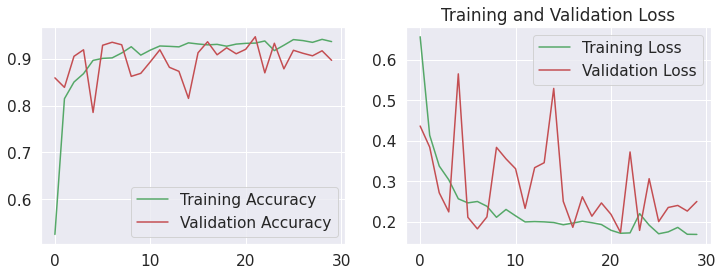

30/30 [==============================] - 6s 194ms/step


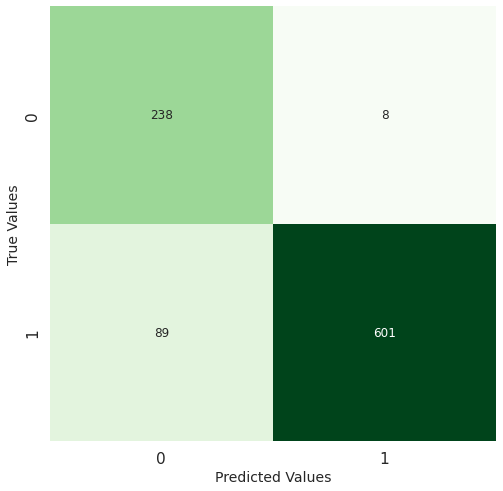

Validation metrics
Accuracy: 89.64%
Recall: 87.10%
Specificity: 96.75%
False Positive Rate: 3.25%


In [142]:
epochs=30
plot_fun(model4_fit, epochs, 'model_4_accuracy')
confusion_matrix_plot(val_ds, model4, 'model_4_confusion_matrix')

### Discussion

Data augmentation produces more images by zooming and rotating the current images I have in the dataset. This will increase the amount of data when training the models and may reduce overfitting. Model 4 has reduced the false positive rate by half over models 1, 2, and 3, but this comes at the expense of reducing the validation accuracy to 90%, right at the cut-off point I gave at the beginning of this analysis. Recall has dropped to below 90% which is not good for our application.

I may be able to improve on model 4 by using transfer learning with a pre-trained model, VGG19. These are models that have been trained on millions of images for image detection and classification.

## Model 5

To increase the effectiveness of the CNN to classify the X-ray data we can use pretrained model to help. A pretrained model is one that has been classified on a large sample of data. The VGG19 pretrained model is a CNN that is 19 layers deep and has been trained on over one million from the ImageNet database. The layers of VGG19 will not be trained on the new data so that their weights will be kept to take advantage of transfer learning. After VGG19, the model will be flattened and go to a dense layer and dropout layer as in the previous models.

In [24]:
# Model with transfer learning
from keras.applications import VGG19

# Initiate the pretrained model VGG19
conv_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(img_height, img_width, 3))

conv_base.trainable = False # Freezes all the layers

conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [39]:
# Model 5
# With a pretrained model

learning_rate = 5e-4

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs)
#x = Rescaling(1./255)(x) # Rescaling causes the accuracy to drop considerably so remove
x = Conv2D(3,(3,3), padding='same')(x)
x = keras.applications.vgg19.preprocess_input(x) # This must do rescaling as the model never converges
                                                 # when using rescaling above
x = conv_base(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs, outputs, name='model_5')

# Compile
model5.compile(loss='binary_crossentropy',
               optimizer=keras.optimizers.Adam(learning_rate),
               metrics = ['accuracy', 
                           keras.metrics.Recall(),
                           keras.metrics.SpecificityAtSensitivity(0.9),
                           keras.metrics.SensitivityAtSpecificity(0.9)])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/m5.keras',
        save_best_only=True,
        monitor='val_loss')
]

In [40]:
#batch_size = 32
epochs = 40 #30
model5_fit = model5.fit(train_ds,
                        #steps_per_epoch=len(train_ds),
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         class_weight=class_weights)

Epoch 1/40


59/59 [==============================] - 1397s 24s/step - loss: 6.7655 - accuracy: 0.8645 - recall_10: 0.8640 - specificity_at_sensitivity_10: 0.6049 - sensitivity_at_specificity_10: 0.0000e+00 - val_loss: 3.7630 - val_accuracy: 0.9338 - val_recall_10: 0.9812 - val_specificity_at_sensitivity_10: 0.8089 - val_sensitivity_at_specificity_10: 0.0000e+00
Epoch 2/40
59/59 [==============================] - 1389s 24s/step - loss: 3.7382 - accuracy: 0.9112 - recall_10: 0.9109 - specificity_at_sensitivity_10: 0.9186 - sensitivity_at_specificity_10: 0.9227 - val_loss: 2.1700 - val_accuracy: 0.9434 - val_recall_10: 0.9464 - val_specificity_at_sensitivity_10: 0.9472 - val_sensitivity_at_specificity_10: 0.9522
Epoch 3/40
59/59 [==============================] - 1386s 24s/step - loss: 4.0447 - accuracy: 0.8994 - recall_10: 0.8992 - specificity_at_sensitivity_10: 0.8971 - sensitivity_at_specificity_10: 0.8999 - val_loss: 15.0126 - val_accuracy: 0.7361 - val_recall_10: 0.6449 - val_specificity_at_sens

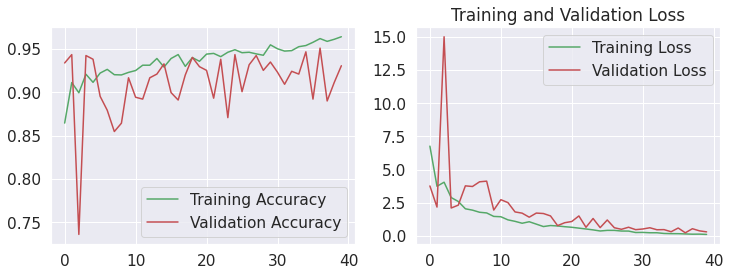

30/30 [==============================] - 129s 4s/step


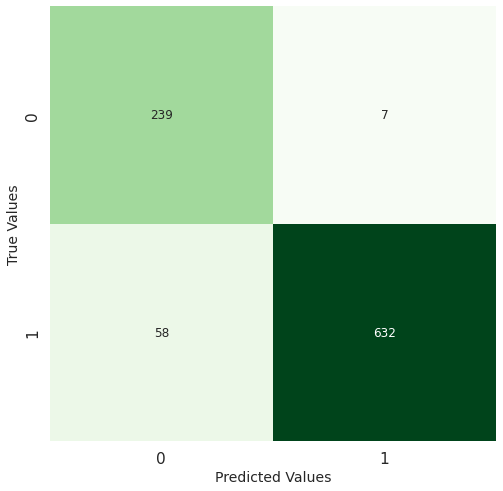

Validation metrics
Accuracy: 93.06%
Recall: 91.59%
Specificity: 97.15%
False Positive Rate: 2.85%


In [143]:
epochs=40
plot_fun(model5_fit, epochs, 'model_5_accuracy')
confusion_matrix_plot(val_ds, model5, 'model_5_confusion_matrix')

### Discussion: Model 5
Transfer learning by using the pre-trained model VGG19 has reduced the false positive rate to the smallest amount so far in this analysis, beating models 1-4. Accuracy and recall has also improved above of model 4 and is above the 90% cut-off but still below models 1, 2, and 3.

# Evaluation
Model 5 seems to be the best model when evaluating ove the best model when evaluating over the validation dataset. Now I will evaluate the metrics of the models over the testing dataset.

Model 1
37/37 [==============================] - 2s 46ms/step


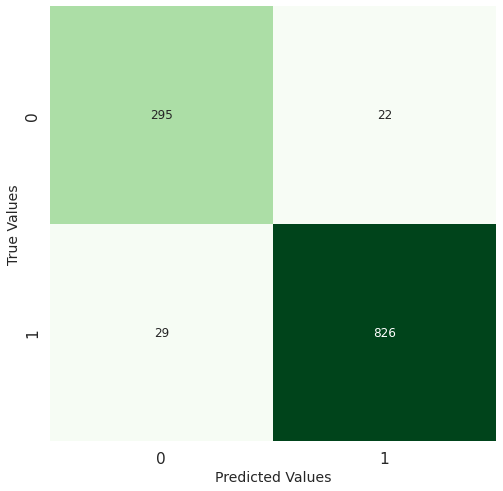

Metrics
Accuracy: 95.65%
Recall: 96.61%
Specificity: 93.06%
False Positive Rate: 6.94%

 Model 2
37/37 [==============================] - 8s 223ms/step


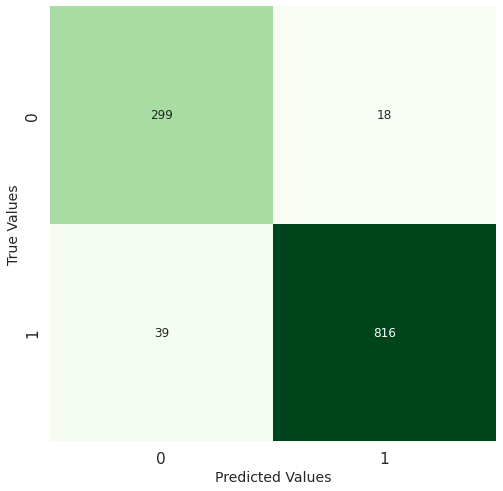

Metrics
Accuracy: 95.14%
Recall: 95.44%
Specificity: 94.32%
False Positive Rate: 5.68%

 Model 3


NameError: name 'model3' is not defined

In [24]:
print(f'Model 1')
confusion_matrix_plot(test_ds, model_baseline, 'model1_test_cm')
print(f'\n Model 2')
confusion_matrix_plot(test_ds, model2, 'model2_test_cm')
print(f'\n Model 3')
confusion_matrix_plot(test_ds, model3, 'model3_test_cm')
print(f'\n Model 4')
confusion_matrix_plot(test_ds, model4, 'model4_test_cm')
print(f'\n Model 5')
confusion_matrix_plot(test_ds, model5, 'model5_test_cm')

## Evaluation Discussion
Model 5 is the best model to use for deployment for the pneumonia prediction application. While it does not have the highest specificity and lowest false positive rate, its specificity is above 95% and false positive rate is below 5%. This indicates that the model is not incorrectly classifying x-rays that indicate pneumonia as 'normal'. While model 4 also has the highest specificity and lowest false positve rate, its recall is below 90%. Recall measures how well a model can detect positive instances (pneumonia) and indicates that it does not have a lot of sensitivity to identify x-rays that have pneumonia.

## Deployment
To solve the business problem, an application must be devloped to deploy the model for healthcare providers can use to classify a chest x-ray as 'normal' or with 'pneumonia'. Using `tensorflow` and `keras` I can load a chest x-ray image and convert that to a tensor. That tensor is inputted into the model where the results will be 'normal' or 'pneumonia' classification.

The pneumonia classificaiton app prototype is deployed using [Steamlit](https://kjspring-x-ray-pneumonia-prediction-app-app-bmt24r.streamlit.app/).

In [165]:
def predict_pneumonia(img_source, model):
    from tensorflow.keras.utils import load_img, img_to_array
    from tensorflow import keras
    import numpy as np
    
    # Load the model from the file
    model = keras.models.load_model(model)
    
    # Load the image
    img = load_img(img_source,
                   color_mode='grayscale',
                   target_size=(240,240))
    
    # Construct the tensor that .predict is expecting
    #img = load_img(img_source, target_size=(64, 64))
    img = img_to_array(img)
    data = np.expand_dims(img, axis=0)#/255
    #print(data)
    
    # get the prediction and return
    prediction = model.predict(data, verbose=0)
    if prediction < 0.5:
        print('Predict: normal chest x-ray')
    else:
        print('Predict: pneumonia chest x-ray')
    #print(prediction)
    return prediction # return position of the highest probability

In [166]:
# Test Prediction
# Baseline Model
model_src = 'models/keras/baseline_model.keras'

print('M1: Baseline Model')
print('Training Data normal x-ray')
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train normal data

print('Training Data pneumonia x-ray')
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # train pneumonia data

print('Normal x-ray from web')
predict_pneumonia('img/app_img.jpeg', model_src) # normal x-ray from web

print('Pneumonia x-ray from web')
predict_pneumonia('img/app_img_pneumonia.jpg', model_src) # pneumonia x-ray from web

print('Image that is not an x-ray')
predict_pneumonia('img/apple.jpeg', model_src) # not x-ray

M1: Baseline Model
Training Data normal x-ray
Predict: normal chest x-ray
Training Data pneumonia x-ray
Predict: pneumonia chest x-ray
Normal x-ray from web
Predict: pneumonia chest x-ray
Pneumonia x-ray from web
Predict: pneumonia chest x-ray
Image that is not an x-ray
Predict: pneumonia chest x-ray


array([[0.9976029]], dtype=float32)

In [160]:
# Test Prediction
# Model 2
model_src = 'models/keras/model2.keras'

print('If > 0.5 then pneumonia')
print('Training Data normal x-ray')
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train normal data

print('Training Data pneumonia x-ray')
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # train pneumonia data

print('Normal x-ray from web')
predict_pneumonia('img/app_img.jpeg', model_src) # normal x-ray from web

print('Pneumonia x-ray from web')
predict_pneumonia('img/app_img_pneumonia.jpg', model_src) # pneumonia x-ray from web

print('Image that is not an x-ray')
predict_pneumonia('img/apple.jpeg', model_src) # not x-ray

If > 0.5 then pneumonia
Training Data normal x-ray
normal chest x-ray
Training Data pneumonia x-ray
pneumonia chest x-ray
Normal x-ray from web
pneumonia chest x-ray
Pneumonia x-ray from web
pneumonia chest x-ray
Image that is not an x-ray
pneumonia chest x-ray


array([[0.9938455]], dtype=float32)

In [161]:
# Test Prediction
# Baseline Model
model_src = 'models/keras/model3.keras'

print('If > 0.5 then pneumonia')
print('Training Data normal x-ray')
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train normal data

print('Training Data pneumonia x-ray')
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # train pneumonia data

print('Normal x-ray from web')
predict_pneumonia('img/app_img.jpeg', model_src) # normal x-ray from web

print('Pneumonia x-ray from web')
predict_pneumonia('img/app_img_pneumonia.jpg', model_src) # pneumonia x-ray from web

print('Image that is not an x-ray')
predict_pneumonia('img/apple.jpeg', model_src) # not x-ray

If > 0.5 then pneumonia
Training Data normal x-ray
normal chest x-ray
Training Data pneumonia x-ray
pneumonia chest x-ray
Normal x-ray from web
pneumonia chest x-ray
Pneumonia x-ray from web
pneumonia chest x-ray
Image that is not an x-ray
pneumonia chest x-ray


array([[0.999829]], dtype=float32)

In [162]:
# Test Prediction
# Model 4
model_src = 'models/keras/model4.keras'

print('If > 0.5 then pneumonia')
print('Training Data normal x-ray')
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train normal data

print('Training Data pneumonia x-ray')
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # train pneumonia data

print('Normal x-ray from web')
predict_pneumonia('img/app_img.jpeg', model_src) # normal x-ray from web

print('Pneumonia x-ray from web')
predict_pneumonia('img/app_img_pneumonia.jpg', model_src) # pneumonia x-ray from web

print('Image that is not an x-ray')
predict_pneumonia('img/apple.jpeg', model_src) # not x-ray

If > 0.5 then pneumonia
Training Data normal x-ray
normal chest x-ray
Training Data pneumonia x-ray
pneumonia chest x-ray
Normal x-ray from web
pneumonia chest x-ray
Pneumonia x-ray from web
normal chest x-ray
Image that is not an x-ray
normal chest x-ray


array([[6.1074704e-12]], dtype=float32)

In [163]:
# Test Prediction
# Model 5
model_src = 'models/keras/m5.keras'

print('If > 0.5 then pneumonia')
print('Training Data normal x-ray')
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train normal data

print('Training Data pneumonia x-ray')
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # train pneumonia data

print('Normal x-ray from web')
predict_pneumonia('img/app_img.jpeg', model_src) # normal x-ray from web

print('Pneumonia x-ray from web')
predict_pneumonia('img/app_img_pneumonia.jpg', model_src) # pneumonia x-ray from web

print('Image that is not an x-ray')
predict_pneumonia('img/apple.jpeg', model_src) # not x-ray

If > 0.5 then pneumonia
Training Data normal x-ray
normal chest x-ray
Training Data pneumonia x-ray
pneumonia chest x-ray
Normal x-ray from web
normal chest x-ray
Pneumonia x-ray from web
pneumonia chest x-ray
Image that is not an x-ray
pneumonia chest x-ray


array([[1.]], dtype=float32)

## Prediction Function discussion
The best model from the output of the prediction function would be model 5. It is able to distinguish images with and without pneumonia but has trouble identifying non-xray images, as the image of an apple in my tests. I included images randomly download from a google search for normal and pneumonia chest x-rays and model 5 also correctly classified these x-rays. The baseline model, model 2, and model 3 classifies all these images download from the internet as having pneumonia except the normal X-ray in the training data. This includes classifing the image of the apple as having pneumonia. Model 4 acurately classifies that the apple image does not have pneumonia, but it fails to correctly classify a x-ray with pneumonia downloaded from the internet.

Deploying a model that classifies images such as an apple as having pneumonia would greatly reduce confidence in the pneumonia prediction tool but model 5 is able to accurately classify images it has not seen before.

# Conclusions and Recommendations
The five models built for this analysis all did very well in accuracy, specificity, and recall. Accuracy is the ability to correctly predict pneumonia and normal cases out of all the classifications. Models 4 and 5 used data augmentation which may have contributed to the lower accuracy, but this was still above the 90% cut off I chose for this anaysis. 

Specificity is the ability of a model to correctly classify the negative case (normal). This is very important for our business problem because incorrectly classing an x-ray image as normal when in fact the patient has pneumonia may cause more harm for the patient. Their x-ray would not be forwarded for confirmation and they may not be treated for pneumonia quickly enough to prevent complications due to pneumonia. 

Althought models 1, 2, and 3 all had high accuracy of above 95%, recall values above 95%, and specificity values above 91% on the testing data, they did not perform well when the model was used to classify images randomly downloaded from the internet that did not have association with the training or testing data as used in this analysis. All three incorrectly classified a normal x-ray as having pneumonia. This would indicate that the recall value would decrease if they are used in production.

Model 4 had the worse result for recall and was below the 90% baseline I chose for this analysis. Model 4 has the best specificity score that is above 98%. Specificity is the ability to correctly identify the negative case (normal). This may be the reason it is able to classify the image of an apple as normal while the other models were unable to do this. It may be productive to add a third option to the models that correctly classify images as not x-ray images buy this may reduce the accuracy of the Pneumonia Classificaiton App.

Although model 5 has a lower accuracy and sensitivity scores from the testing data than models 1, 2, and 3, it does perform very well in specificity. Model 5 also correctly classifies all x-ray images that were downloaded from the internet in the prediction app testing. This may work better in a production environment that models 1 to 4.


## Recommendatons
* Use
* Use model 5 in the beta version of the deployed pneumonia classification web app for our healthcare partners
* Include a mechanism in the Pneumonia Classificatoin App for healthcare workers to leave feedback on the quality of the app's classification of the models.
* Expand the model to have three possible classifications
    * Pneumonia
    * Normal
    * Not an x-ray